In [ ]:
%cd ..

In [2]:
import argparse
import collections
import random
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np
import data_loader.data_loaders as module_data
import model.model as module_arch
from parse_config import ConfigParser
from trainer import Trainer

In [3]:
%matplotlib inline

In [4]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [5]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

In [6]:
Args = collections.namedtuple('Args', 'config resume device')
config = ConfigParser.from_args(Args(config='chemical_config.json', resume=None, device=None))

In [7]:
logger = config.get_logger('train')

In [8]:
# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

In [9]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch, len(data_loader.dataset.alphabet), data_loader.dataset.max_len)

In [10]:
model.resume_from_checkpoint('saved/models/SelfiesAutoencodingOperad/0905_154251/checkpoint-epoch5000.pth')

In [11]:
validation_data = random.choice(list(valid_data_loader))[0]

In [12]:
path, prediction_data = model(observations=validation_data, train=False)

In [13]:
prediction_data = prediction_data.view(-1, *model._data_space)

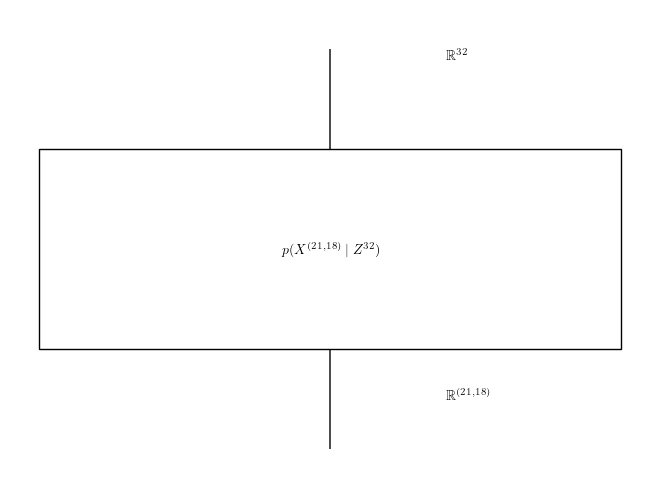

In [14]:
path.draw()

In [15]:
path.draw(path='chemical_string_diagram.pdf')

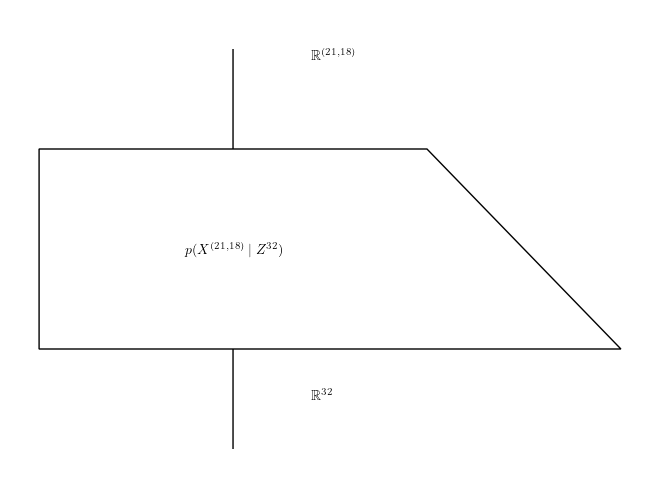

In [16]:
path.dagger().draw()

In [17]:
from discopy.monoidal import Ty
import base.base_type as types

In [18]:
model._operad.draw(notebook=True, filename='chemical_vae_freeop.html')

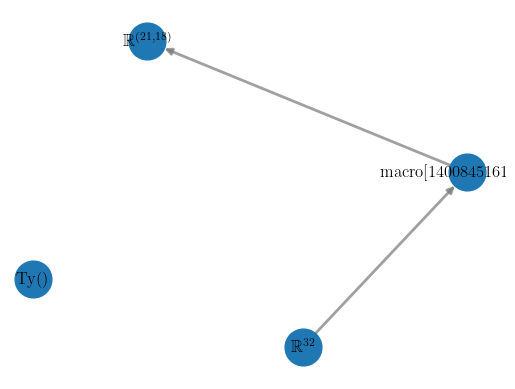

In [19]:
model._operad.draw(notebook=False, filename='chemical_vae_freeop.pdf')

In [20]:
validation_data.shape

torch.Size([256, 21, 18])

In [21]:
m, reconstructions = model(observations=validation_data, train=False)

In [22]:
(reconstructions == validation_data).all(dim=-1).to(dtype=torch.float).mean(dim=0)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])

In [23]:
from utils import mol_utils

In [24]:
validation_mols = data_loader.dataset.to_mols(validation_data)
reconstruction_mols = data_loader.dataset.to_mols(reconstructions)

Enabling RDKit 2023.03.1 jupyter extensions


In [25]:
import logging
import matplotlib.pyplot as plt

In [26]:
NUM_RECONS = 10

n = 0
k = 0

while n < NUM_RECONS and k < len(validation_mols):
    mols = reconstruction_mols[k], validation_mols[k]
    if mols[0] and mols[1]:
        mol_utils.draw_mols(mols, 2)
        plt.show()
        n += 1
    else:
        logging.info('Invalid reconstruction!')
        mol_utils.draw_mol(mols[1])
        plt.show()
    k += 1

In [27]:
samples = []
for _ in range(10000 // 200):
    with torch.no_grad():
        morphism, output = model(observations=None, num_samples=200)
        samples = samples + data_loader.dataset.to_smiles(output)

In [28]:
import pandas as pd

In [29]:
samples = pd.Series(data=samples)

In [30]:
len(samples.unique())

5101

In [31]:
len(samples.unique()) / 10000.

0.5101